<a href="https://colab.research.google.com/github/523550914/Algorithm/blob/main/q1_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 导包

In [ ]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#导入强大的绘图库
import torch#一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.optim as optim#一个实现了各种优化算法的库
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别.
from sklearn.preprocessing import MinMaxScaler


In [ ]:
#设置随机种子
import random
torch.backends.cudnn.deterministic = True#将cudnn框架中的随机数生成器设为确定性模式
torch.backends.cudnn.benchmark = False#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### 配置

In [ ]:
config = {
  "time_step": 12,
  "is_cv":True,
  "ratio":0.8 if config["is_cv"] else 0.75
}

### 数据预处理

In [ ]:
def func(df):# 构造滞后值特征
    for i in range(1, 13):  # 使用过去 12 个月的数据作为滞后值特征
        df[f'Lag_{i}'] = df['number'].shift(i)

    # 构造移动平均特征
    df['Moving_Average_3'] = df['number'].rolling(window=3).mean().shift(1)
    df['Moving_Average_6'] = df['number'].rolling(window=6).mean().shift(1)

    # 构造季节性指标
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Weekday'] = df['date'].dt.weekday

    # 构造趋势指标
    df['Trend'] = range(1, len(df) + 1)
    return df

In [ ]:
# 假设这是您确定的2023年的节假日日期列表
holiday_dates = ['2023-10-01', '2023-10-02', # 国庆节
                 '2023-10-03', '2023-10-04',
                 '2023-10-05', '2023-10-06',
                 '2023-10-07',
                 '2023-09-29', '2023-09-30' # 中秋节
                 # 添加其他节假日...
                ]
# 将字符串日期转换为datetime对象
holiday_dates = pd.to_datetime(holiday_dates)

In [ ]:
# 指定日期
special_dates = ['2023-10-24', '2023-11-01', '2023-11-11']
special_dates = pd.to_datetime(special_dates)

# 定义一个函数来计算与指定日期的天数差，并根据天数差返回相应的值
def mark_special_days(date):
    # 初始化标记值为0
    mark = 0
    # 计算与每个指定日期的天数差
    for special_date in special_dates:
        days_diff = (date - special_date).days
        # 如果天数差在1到7之间，则设置标记值为8减去天数差
        if 0 <= days_diff <= 6:
            mark = 7 - days_diff
            break  # 找到一个符合条件的日期后即可跳出循环
    return mark

# 应用函数，添加新列


In [ ]:
if config["is_cv"]:
  df_day = pd.read_csv(r"F:\Typora\daily_learning\daily_learning\妈妈杯\data\1.csv")
else:
  df_day = pd.read_csv(r"F:\Typora\daily_learning\daily_learning\妈妈杯\data\test1.csv")
df_day["date"] = pd.to_datetime(df_day["date"])
df_day['Is_Holiday_or_Sunday'] = df_day['date'].apply(lambda x: 1 if (x in holiday_dates) or (x.weekday() == 6) else 0)
df_day['Shopping_Holiday'] = df_day['date'].apply(mark_special_days)
df_day = df_day.sort_values(by=['session'])
df_day = df_day.groupby('session').apply(lambda x: x.sort_values('date')).reset_index(drop=True)
print(df_day.head())

  session       date  number  Is_Holiday_or_Sunday  Shopping_Holiday
0     SC1 2023-08-01   39517                     0                 0
1     SC1 2023-08-02   40008                     0                 0
2     SC1 2023-08-03   38477                     0                 0
3     SC1 2023-08-04   35773                     0                 0
4     SC1 2023-08-05   31876                     0                 0


### 获得动静态特征

In [ ]:
def get_static_fe_by_day(df, session):
    # Filter the DataFrame based on the session parameter
    filtered_df = df[df['session'] == session]
    filtered_df = func(filtered_df)
    filtered_df['combined_features'] = filtered_df[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5',
                                                'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10',
                                                'Lag_11', 'Lag_12', 'Trend', 'Moving_Average_6',
                                                'Moving_Average_3', 'Is_Holiday_or_Sunday',
                                                'Shopping_Holiday']].values.tolist()
    static_features_list = filtered_df['combined_features'].apply(lambda x: [0 if pd.isna(i) else i for i in x])

    # 将列表的列表转换为PyTorch Tensor
    static_features_tensor = torch.tensor(static_features_list.tolist())

    return static_features_tensor

In [ ]:
def get_number_by_day(df,session):
    session_data = df[df['session'] == session]
    number_by_day =session_data["number"].values
    number_by_day = torch.tensor(number_by_day)
    return number_by_day

In [ ]:
# 分割时间窗口
def split_data(data,time_step=12):
    dataX=[]
    datay=[]
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    return dataX,datay

In [ ]:
def train_test_split(dataX,datay,shuffle=True,percentage=config['ratio']):
    """
    将训练数据X和标签y以numpy.array数组的形式传入
    划分的比例定为训练集:测试集=8:2
    """
    if shuffle:
        random_num=[index for index in range(len(dataX))]
        np.random.shuffle(random_num)
        dataX=dataX[random_num]
        datay=datay[random_num]
    split_num=int(len(dataX)*percentage)
    train_X=dataX[:split_num]
    train_y=datay[:split_num]
    test_X=dataX[split_num:]
    test_y=datay[split_num:]
    return train_X,train_y,test_X,test_y

In [ ]:
scaler1 = MinMaxScaler()
def load_and_transform_data(df_day, i, config):
    number_by_day = get_number_by_day(df_day, i)

    number_by_day_scaled = scaler1.fit_transform(number_by_day.reshape(-1,1))


    static_fe_by_day = get_static_fe_by_day(df_day, i)
    scaler2 = MinMaxScaler()
    # 直接对原始形状应用标准化，无需reshape
    static_fe_by_day_scaled = scaler2.fit_transform(static_fe_by_day)

    dynamic_dataX, dynamic_dataY = split_data(number_by_day_scaled, config["time_step"])
    static_dataX, static_dataY = split_data(static_fe_by_day_scaled, config["time_step"])

    return dynamic_dataX, dynamic_dataY, static_dataX, static_dataY

### 定义模型

##### 定义模型的参数

In [ ]:
config = {
    "time_step": 12,
    "input_size":1,  # 输入特征维度
    "conv_input":12,
    "hidden_size":64,  # LSTM隐藏状态维度
    "num_layers":7 , # LSTM层数
    "output_size":1,  # 输出维度（预测目标维度）
    "static_size ":40,
    "num_epochs":1000,
    "batch_size":32
}
input_size = config["input_size"]  # 输入特征维度
conv_input=config["conv_input"]
hidden_size = config["hidden_size"]  # LSTM隐藏状态维度
num_layers = config["num_layers"]  # LSTM层数
output_size = config["output_size"]  # 输出维度（预测目标维度）
static_size = config["static_size"]
num_epochs=config["num_epochs"]
batch_size=config["batch_size"]
dropout_rate = config["dropout_rate"]

##### 定义模型

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, conv_input,input_size, hidden_size, num_layers, output_size, static_size):
        super(CNN_LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 动态数据的处理层
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.relu1 = nn.ReLU()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2 if num_layers > 1 else 0.0)

        # 静态数据的处理层
        self.static_fc = nn.Linear(static_size, 32)  # 假设静态数据输出32维
        self.relu2 = nn.ReLU()
        # 结合动态和静态数据后的输出层
        self.fc = nn.Linear(hidden_size+32, output_size)
        self.relu3 = nn.ReLU()
    def forward(self, dynamic_data, static_data):
        x=self.conv(dynamic_data)
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        dynamic_out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        dynamic_out = dynamic_out[:, -1, :]
        # 处理静态数据
        static_out = self.static_fc(static_data)
        static_out = self.relu2(static_out)
        static_out = static_out[:, -1, :]

        combined_out = torch.cat((dynamic_out, static_out), dim=1)  # 合并动态和静态数据的输出

        out = self.fc(combined_out)
        out = self.relu3(out)
        return out

##### 训练

In [ ]:
def mse(pred_y,true_y):
    return np.mean((pred_y-true_y) ** 2)

def r_squared(pred_y, true_y):
    # 计算预测值与真实值的平均值
    mean_true_y = np.mean(true_y)
    # 计算总平方和
    total_sum_of_squares = np.sum((true_y - mean_true_y) ** 2)
    # 计算残差平方和
    residual_sum_of_squares = np.sum((true_y - pred_y) ** 2)
    # 计算 R²
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r_squared

In [ ]:
def reset_weights(m):
    """
    该函数尝试重置模型中的所有参数。
    """
    for layer in m.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()

正在处理第sessionSC1
start
epoch:0,train_loss:0.042594991624355316,test_loss:0.08321109414100647
epoch:50,train_loss:0.011326972395181656,test_loss:0.06853187084197998
epoch:100,train_loss:0.015072839334607124,test_loss:0.08249814063310623
epoch:150,train_loss:0.009912403300404549,test_loss:0.0466320775449276
epoch:200,train_loss:0.006150986533612013,test_loss:0.04916657134890556
epoch:250,train_loss:0.01122599933296442,test_loss:0.05082499608397484
epoch:300,train_loss:0.008500702679157257,test_loss:0.05462350696325302
epoch:350,train_loss:0.0048918165266513824,test_loss:0.041623618453741074
epoch:400,train_loss:0.008727340027689934,test_loss:0.05322514846920967
epoch:450,train_loss:0.008746356703341007,test_loss:0.04438822716474533
epoch:500,train_loss:0.010350577533245087,test_loss:0.04667344316840172
epoch:550,train_loss:0.0032620159909129143,test_loss:0.049655914306640625
epoch:600,train_loss:0.009524190798401833,test_loss:0.06917544454336166
epoch:650,train_loss:0.008196081034839153,t

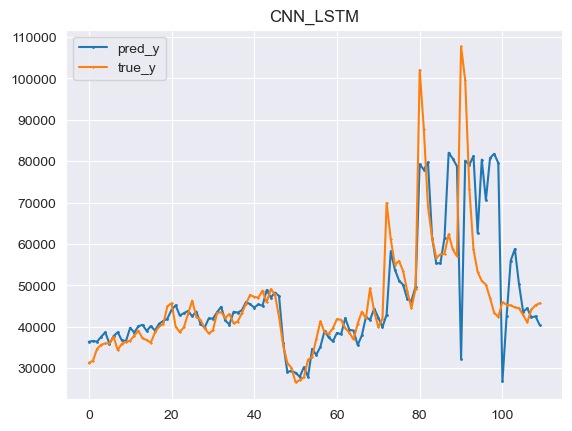

正在处理第sessionSC10
start
epoch:0,train_loss:0.05609296262264252,test_loss:0.2320084571838379
epoch:50,train_loss:0.037647683173418045,test_loss:0.13183550536632538
epoch:100,train_loss:0.014414377510547638,test_loss:0.028850169852375984
epoch:150,train_loss:0.010195511393249035,test_loss:0.028208529576659203
epoch:200,train_loss:0.003531714901328087,test_loss:0.02793857641518116
epoch:250,train_loss:0.006511062849313021,test_loss:0.02795063704252243
epoch:300,train_loss:0.007676723878830671,test_loss:0.02787039428949356
epoch:350,train_loss:0.008656186982989311,test_loss:0.027718983590602875
epoch:400,train_loss:0.005603617522865534,test_loss:0.027604836970567703
epoch:450,train_loss:0.007388229016214609,test_loss:0.028599204495549202
epoch:500,train_loss:0.005402640905231237,test_loss:0.02801092155277729
epoch:550,train_loss:0.00899503007531166,test_loss:0.03440755233168602
epoch:600,train_loss:0.003505686530843377,test_loss:0.027692995965480804
epoch:650,train_loss:0.002119706477969885

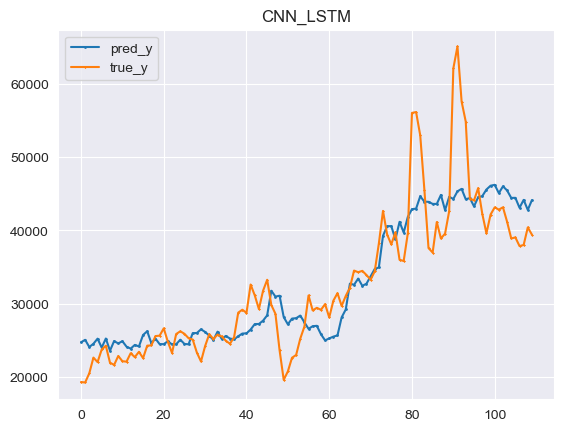

正在处理第sessionSC12
start
epoch:0,train_loss:0.03737331181764603,test_loss:0.10941838473081589
epoch:50,train_loss:0.004792733583599329,test_loss:0.04570038616657257
epoch:100,train_loss:0.019080325961112976,test_loss:0.04580654203891754
epoch:150,train_loss:0.030592210590839386,test_loss:0.045153092592954636
epoch:200,train_loss:0.013765711337327957,test_loss:0.06166285648941994
epoch:250,train_loss:0.006556080654263496,test_loss:0.04642719030380249
epoch:300,train_loss:0.013196875341236591,test_loss:0.04777992144227028
epoch:350,train_loss:0.01827154867351055,test_loss:0.05362629517912865
epoch:400,train_loss:0.010654466226696968,test_loss:0.06475017219781876
epoch:450,train_loss:0.004915687255561352,test_loss:0.06958664953708649
epoch:500,train_loss:0.005742998793721199,test_loss:0.04940049350261688
epoch:550,train_loss:0.003118235617876053,test_loss:0.05590400844812393
epoch:600,train_loss:0.0020953877829015255,test_loss:0.05209287628531456
epoch:650,train_loss:0.01282223779708147,tes

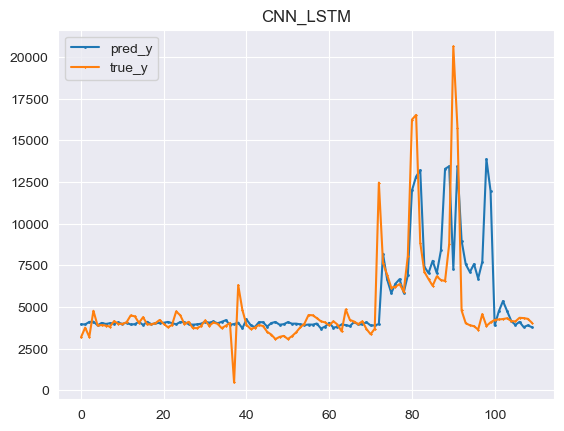

正在处理第sessionSC14
start
epoch:0,train_loss:0.06511859595775604,test_loss:0.054311808198690414
epoch:50,train_loss:0.053690407425165176,test_loss:0.054311808198690414
epoch:100,train_loss:0.04899338260293007,test_loss:0.054311808198690414
epoch:150,train_loss:0.05956689640879631,test_loss:0.054311808198690414
epoch:200,train_loss:0.0440998412668705,test_loss:0.054311808198690414
epoch:250,train_loss:0.05095404386520386,test_loss:0.054311808198690414
epoch:300,train_loss:0.06430533528327942,test_loss:0.054311808198690414
epoch:350,train_loss:0.06571496278047562,test_loss:0.054311808198690414
epoch:400,train_loss:0.060975126922130585,test_loss:0.054311808198690414
epoch:450,train_loss:0.048759203404188156,test_loss:0.054311808198690414
epoch:500,train_loss:0.0489545613527298,test_loss:0.054311808198690414
epoch:550,train_loss:0.0650453194975853,test_loss:0.054311808198690414
epoch:600,train_loss:0.0671766847372055,test_loss:0.054311808198690414
epoch:650,train_loss:0.05759013071656227,test

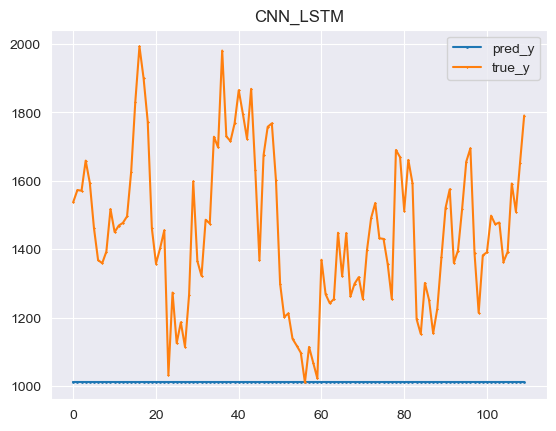

正在处理第sessionSC15
start
epoch:0,train_loss:0.31268641352653503,test_loss:0.34886714816093445
epoch:50,train_loss:0.2991322875022888,test_loss:0.34886714816093445
epoch:100,train_loss:0.31746557354927063,test_loss:0.34886714816093445
epoch:150,train_loss:0.2811381220817566,test_loss:0.34886714816093445
epoch:200,train_loss:0.26368460059165955,test_loss:0.34886714816093445
epoch:250,train_loss:0.3006317615509033,test_loss:0.34886714816093445


KeyboardInterrupt: 

In [ ]:
%%time
import torch
import torch.nn as nn
for i in df_day['session'].unique():
    dynamic_dataX, dynamic_dataY, static_dataX, static_dataY = load_and_transform_data(df_day, i, config)
    dynamic_train_X,dynamic_train_y,dynamic_test_X,dynamic_test_y=train_test_split(dynamic_dataX,dynamic_dataY,shuffle=False)
    static_train_X,static_train_y,static_test_X,static_test_y=train_test_split(static_dataX,static_dataY ,shuffle=False)
    dynamic_X_train,dynamic_y_train=dynamic_train_X,dynamic_train_y
    static_X_train,static_y_train = static_train_X,static_train_y

    dynamic_X_test,dynamic_y_test = dynamic_test_X,dynamic_test_y
    static_X_test,static_y_test = static_test_X,static_test_y


    print(f'正在处理第session{i}')
    model =CNN_LSTM(conv_input,input_size, hidden_size, num_layers, output_size,static_size)
    optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.5,0.999))
    criterion=nn.MSELoss()

    train_losses=[]
    test_losses=[]

    print(f"start")
    dynamic_X_test=torch.Tensor(dynamic_X_test)
    dynamic_y_test=torch.Tensor(dynamic_y_test)

    static_X_test=torch.Tensor(static_X_test)
    static_y_test=torch.Tensor(static_y_test)

    for epoch in range(num_epochs):
        random_num=[i for i in range(len(dynamic_train_X))]
        np.random.shuffle(random_num)
        # 动态特征
        dynamic_train_X=dynamic_train_X[random_num]
        dynamic_train_y=dynamic_train_y[random_num]
        dynamic_train_X1=torch.Tensor(dynamic_train_X[:batch_size])
        dynamic_train_y1=torch.Tensor(dynamic_train_y[:batch_size])

        # 静态特征
        static_train_X_by=static_train_X[random_num]
        static_train_y_by=static_train_y[random_num]
        static_train_X1=torch.Tensor(static_train_X[:batch_size])
        static_train_y1=torch.Tensor(static_train_y[:batch_size])

        #训练
        model.train()
        #将梯度清空
        optimizer.zero_grad()
        #将数据放进去训练
        output = model(dynamic_train_X1, static_train_X1)
        #计算每次的损失函数
        train_loss=criterion(output,dynamic_train_y1)
        #反向传播
        train_loss.backward()
        #优化器进行优化(梯度下降,降低误差)
        optimizer.step()
        if epoch%50==0:
          model.eval()
          with torch.no_grad():
              output=model(dynamic_X_test,static_X_test)
              test_loss=criterion(output,dynamic_y_test)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          print(f"epoch:{epoch},train_loss:{train_loss},test_loss:{test_loss}")
    # 集合训练集和验证集的参数
    dynamic_X_train=torch.Tensor(dynamic_X_train)
    static_X_train = torch.Tensor(static_X_train)
    train_pred=model(dynamic_X_train,static_X_train).detach().numpy()
    dynamic_X_test=torch.Tensor(dynamic_X_test)
    static_X_test = torch.Tensor(static_X_test)
    test_pred=model(dynamic_X_test,static_X_test).detach().numpy()
    # 如果是测试集需要保存数据
    if not config['is_cv']:
      split_num = int(0.75 * len(df_day))
      test_indices = df_day.iloc[split_num:].index  # 如果您按某种方式分割了数据
      test_pred_series = pd.Series(test_pred.flatten(), index=test_indices)
      # 将预测结果添加到 DataFrame 中
      df_day.loc[test_indices, 'number'] = test_pred_series
    # 加一行储存model以及清楚model的参数
    pred_y_agg=np.concatenate((train_pred,test_pred))
    pred_y_agg=scaler1.inverse_transform(pred_y_agg).T[0]

    true_y_agg=np.concatenate((dynamic_y_train,dynamic_y_test))
    true_y_agg=scaler1.inverse_transform(true_y_agg).T[0]
    print(f"mse(pred_y,true_y):{mse(pred_y_agg,true_y_agg)}")
    print(f"R2(pred_y,true_y):{r_squared(pred_y_agg,true_y_agg)}")
    plt.title("CNN_LSTM")
    x=[i for i in range(len(true_y_agg))]
    plt.plot(x,pred_y_agg,marker="o",markersize=1,label="pred_y")
    plt.plot(x,true_y_agg,marker="x",markersize=1,label="true_y")
    plt.legend()
    plt.show()

In [ ]:
def reset_weights(m):
    """
    该函数尝试重置模型中的所有参数。
    """
    for layer in m.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()
# 应用重置函数
model.apply(reset_weights)

CNN_LSTM(
  (conv): Conv1d(12, 12, kernel_size=(1,), stride=(1,))
  (relu1): ReLU()
  (lstm): LSTM(1, 64, num_layers=8, batch_first=True, dropout=0.2)
  (static_fc): Linear(in_features=17, out_features=32, bias=True)
  (relu2): ReLU()
  (fc): Linear(in_features=96, out_features=1, bias=True)
  (relu3): ReLU()
)

In [ ]:
# 集合训练集和验证集的参数
dynamic_X_train=torch.Tensor(dynamic_X_train)
static_X_train= static_X_train.float()
train_pred=model(dynamic_X_train,static_X_train).detach().numpy()

test_pred=model(dynamic_test_X,static_X_test).detach().numpy()

# 加一行储存model以及清楚model的参数
torch.save(model.state_dict(), r'F:\Typora\daily_learning\daily_learning\妈妈杯\running_data\model_name.pth')

def reset_weights(m):
    """
    该函数尝试重置模型中的所有参数。
    """
    for layer in m.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()
# 应用重置函数
model.apply(reset_weights)

pred_y_agg=np.concatenate((train_pred,test_pred))
pred_y_agg=scaler.inverse_transform(pred_y_agg).T[0]
true_y_agg=np.concatenate((dynamic_y_train,dynamic_y_test))
true_y_agg=scaler.inverse_transform(true_y_agg).T[0]
print(f"mse(pred_y,true_y):{mse(pred_y_agg,true_y_agg)}")
print(f"R2(pred_y,true_y):{r_squared(pred_y_agg,true_y_agg)}")

AttributeError: 'numpy.ndarray' object has no attribute 'float'